<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC
### Trends and climatology of NO2 

Daily, monthly and annual mean concentrations of NO2 are calculated from one ACTRIS site with a long time series to calculate trends and climatology

### Import libraries

In [159]:
import json
import xarray as xr

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pymannkendall as mk


### Load data

In this example the data is selected by searching in the [ACTRIS Data Portal](https://data.actris.eu) and extracting the URLs to their netCDF files in Thredds. The example shows NO2 from Jungraujoch where the time series for the period 2006-2023 is availible from two different files that needs to be combined.

In [160]:
# NO2 at Jungfraujoch from 2006-2021
URL_first=['https://thredds.nilu.no/thredds/dodsC/ebas_doi/VA/U9/WW/VAU9-WW7S.nc']
# NO2 at Jungfraujoch from 2021-2023
URL_last=['https://thredds.nilu.no/thredds/dodsC/ebas_doi/DQ/83/EQ/DQ83-EQBE.nc']
#combine the two URLs
file_urls = URL_first + URL_last
file_urls

['https://thredds.nilu.no/thredds/dodsC/ebas_doi/VA/U9/WW/VAU9-WW7S.nc',
 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/DQ/83/EQ/DQ83-EQBE.nc']

### Combine the two datasets and calculate daily,monthly and annual mean

In [161]:
# define the variable of interest and the year of interest
variable_interested_standard_name = 'mass_concentration_of_nitrogen_dioxide_expressed_as_nitrogen_in_air'

# define files with the data of interest
daily_means_all = []
monthly_means_all = []
annual_means_all = []


for i in range(len(file_urls)):
    # Open the netCDF file
    data = xr.open_dataset(file_urls[i])
    print(i)

    # check if the dataset contains the variable of interest and print out start and end date of the dataset
    for var in data.data_vars:
        if 'standard_name' in data[var].attrs and data[var].attrs['standard_name'] == variable_interested_standard_name:
            print(' File %d, %s, variable: %s %s Period: %s - %s' % (i, data.attrs['ebas_station_code'], "{:<35s}".format(var), "{:<40s}".format('('+data.attrs['ebas_station_name']+')'), data.time.min().values, data.time.max().values))

            # get the variable values for all the years
            variable_values = data[var]

            # Calculate daily and monthly means
            daily_means = variable_values.resample(time='1D').mean('time')               
            monthly_means = variable_values.resample(time='ME').mean('time')
            annual_means = variable_values.resample(time='YE').mean('time')    
            #add the means to the file that collects all the sites
            daily_means_all.append(daily_means)
            monthly_means_all.append(monthly_means)
            annual_means_all.append(annual_means)            
            break              

    else:
        print(f"File {i} does not contain data ")
data.close() 


0
 File 0, CH0001G, variable: nitrogen_dioxide                    (Jungfraujoch)                           Period: 2006-01-01T00:30:00.000000000 - 2020-12-31T23:30:00.000000000
1
 File 1, CH0001G, variable: nitrogen_dioxide_ug_N_per_m3        (Jungfraujoch)                           Period: 2021-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000


#### Extract the daily, monthly and annual means

In [162]:
def concatenate_time_series(data_arrays, is_annual=False):
    times = []
    values = []
    for data_array in data_arrays:
        if is_annual:
            # Set the time to January 1st of the following year
            times.extend(data_array.time.values + np.timedelta64(1, 'D') - np.timedelta64(184, 'D'))
            values.extend(data_array.values)
        else:
            times.extend(data_array.time.values)
            values.extend(data_array.values)
    return np.array(times), np.array(values)

# Concatenate daily, monthly, and annual means
daily_times, daily_values = concatenate_time_series(daily_means_all)
monthly_times, monthly_values = concatenate_time_series(monthly_means_all)
# Concatenate annual means with adjusted time to 1 july for better visualization
annual_times, annual_values = concatenate_time_series(annual_means_all, is_annual=True)

### Plot the timeserie

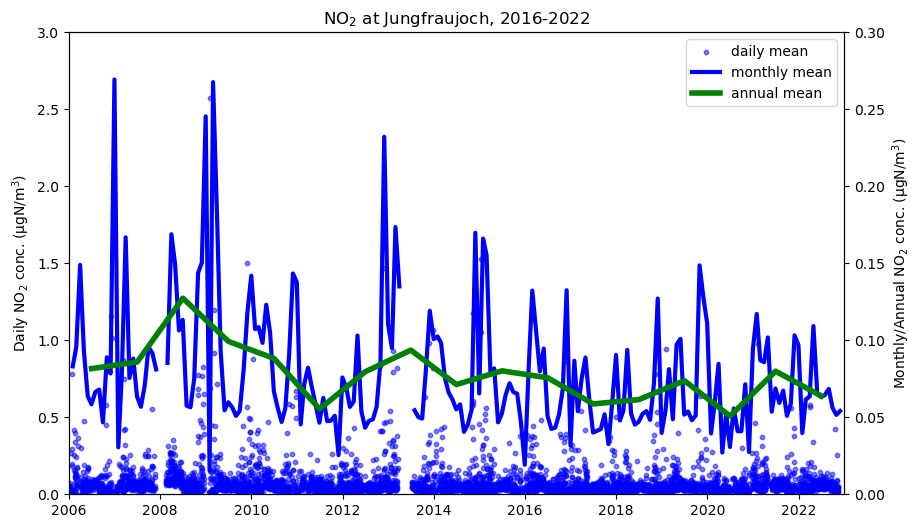

In [163]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define colors for each type of data
daily_color = 'blue'
monthly_color = 'blue'
annual_color = 'green'

# Plot daily means on the primary y-axis
ax1.scatter(daily_times, daily_values, label='daily mean', alpha=0.5, s=10, color=daily_color)

# Set labels for the primary y-axis
ax1.set_ylabel('Daily NO$_2$ conc. (µgN/m$^3$)')
ax1.set_ylim(0, 3)
ax1.set_xlim(daily_times[0], daily_times[-1])

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot monthly means on the secondary y-axis
ax2.plot(monthly_times, monthly_values, label='monthly mean', linewidth=3, color=monthly_color)

# Plot annual means on the secondary y-axis
ax2.plot(annual_times, annual_values, label='annual mean', linewidth=4, color=annual_color)

# Set labels for the secondary y-axis
ax2.set_ylabel('Monthly/Annual NO$_2$ conc. (µgN/m$^3$)')
ax2.set_ylim(0, 0.3)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.title('NO$_2$ at Jungfraujoch, 2016-2022')

# Show the plot
plt.show()

### Calculate trends in NO2

Make a function that calculates MK trend and Sen-Theil slope:

In [164]:
def calculate_trend(data):
    # Convert data to a pandas Series
    series = pd.Series(data)
    
    # Calculate the Mann-Kendall test statistic and p-value
    trend_result = mk.original_test(series)
    p_value = trend_result.p
    
    # Calculate the Sen-Theil slope and intercept
    slope = trend_result.slope
    intercept = trend_result.intercept 
    
    return slope, intercept, p_value

Calculate monthly and annual mean trends and plot

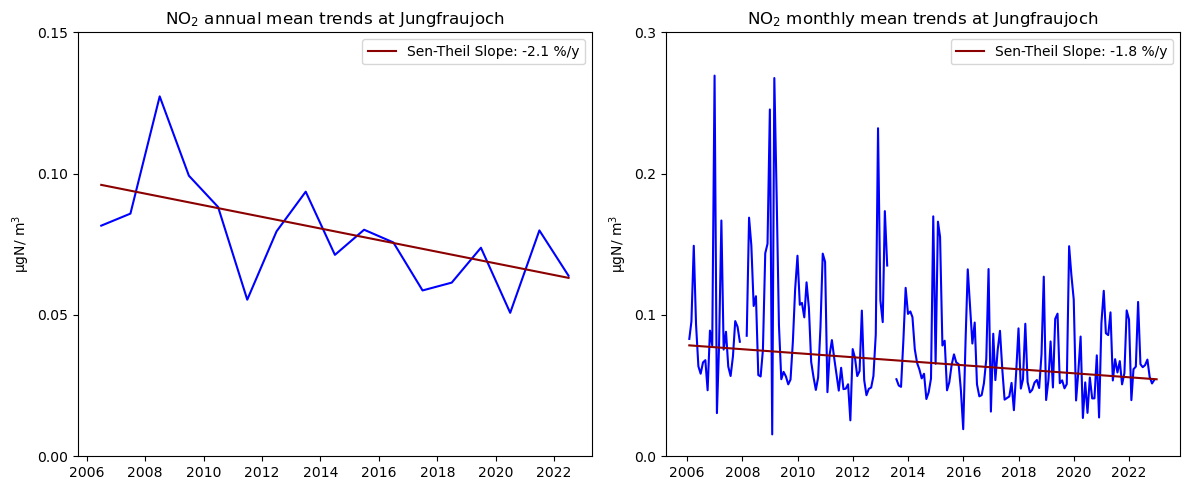

In [165]:
# Create a DataFrame from annual_times and annual_values
df_annual = pd.DataFrame({
    'time': annual_times,
    'value': annual_values
})
# Create a DataFrame from monthly_times and monthly_values
df_monthly = pd.DataFrame({
    'time': monthly_times,
    'value': monthly_values
})

# Calculate the trend for the annual data
data_annual = df_annual.value
slope_annual, intercept_annual, p_value_annual = calculate_trend(data_annual)

years = df_annual.time
sen_annual = [slope_annual * x + intercept_annual for x in range(len(years))]

# Calculate the trend for the monthly data
data_month = df_monthly.value
slope_month, intercept_month, p_value_month = calculate_trend(data_month)

months = df_monthly.time
sen_month = [slope_month * x + intercept_month for x in range(len(months))]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Annual data subplot
axs[0].plot(years, data_annual, color='blue')
if 0 < p_value_annual < 0.05:
    label_annual = f'Sen-Theil Slope: {round(100 * slope_annual / intercept_annual, 1)} %/y'
    axs[0].plot(years, sen_annual, 'darkred', label=label_annual)
else:
    label_annual = f'Sen-Theil Slope: {round(100 * slope_annual / intercept_annual, 1)} %/y'
    axs[0].plot(years, sen_annual, 'darkred', linestyle='--', label=label_annual)

axs[0].set_yticks(np.arange(0, 0.2, step=0.05))
axs[0].set_ylabel("µgN/ m$^{3}$")
axs[0].set_title('NO$_2$ annual mean trends at Jungfraujoch')
axs[0].legend()

# Monthly data subplot
axs[1].plot(months, data_month, color='blue')
if 0 < p_value_month < 0.05:
    label_month = f'Sen-Theil Slope: {round(12 * 100 * slope_month / intercept_month, 1)} %/y'
    axs[1].plot(months, sen_month, 'darkred', label=label_month)
else:
    label_month = f'Sen-Theil Slope: {round(12 * 100 * slope_month / intercept_month, 1)} %/y'
    axs[1].plot(months, sen_month, 'darkred', linestyle='--', label=label_month)


axs[1].set_yticks(np.arange(0, 0.4, step=0.1))
axs[1].set_ylabel("µgN/ m$^{3}$")
axs[1].set_title('NO$_2$ monthly mean trends at Jungfraujoch')
axs[1].legend()

plt.tight_layout()
plt.show()

### Plot monthly mean of 2022 and compare with earlier periods (clinmatology)

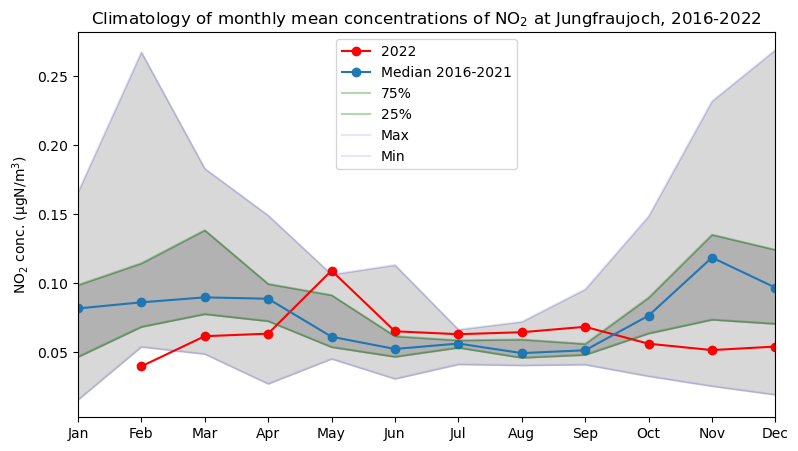

In [166]:
# Extract the month from the time column
df_monthly['month'] = df_monthly['time'].dt.month

# Filter the DataFrame to create two separate DataFrames, 
# one with 2022 data and one with other years
df_2022 = df_monthly[df_monthly['time'].dt.year == 2022].drop(columns=['time'])
df_other_years = df_monthly[df_monthly['time'].dt.year != 2022].drop(columns=['time'])

# Calculate monthly statistics for other years and extract relevant statistics
monthly_stats = df_other_years.groupby('month')['value'].describe()
max_values = monthly_stats['max']
min_values = monthly_stats['min']
q75_values = monthly_stats['75%']
q25_values = monthly_stats['25%']
median_values = monthly_stats['50%']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the statistics
plt.figure(figsize=(9, 5))

plt.plot(df_2022['month'], df_2022['value'], label='2022', marker='o', color='red')
plt.plot(months, median_values, label='Median 2016-2021', marker='o')
plt.plot(months, q75_values, label='75%', color='green', alpha=0.3)
plt.plot(months, q25_values, label='25%', color='green', alpha=0.3)
plt.plot(months, max_values, label='Max',color='blue', alpha=0.1)
plt.plot(months, min_values, label='Min',color='blue', alpha=0.1)

# Add shaded area between Max and 75%
plt.fill_between(months, q75_values, max_values, color='gray', alpha=0.3)
plt.fill_between(months, q25_values, q75_values, color='gray', alpha=0.6)
# Add shaded area between Max and 75%
plt.fill_between(months, q25_values, min_values, color='gray', alpha=0.3)

plt.xlim(months[0], months[11])
plt.ylabel('NO$_2$ conc. (µgN/m$^3$)')
plt.title('Climatology of monthly mean concentrations of NO$_2$ at Jungfraujoch, 2016-2022')
plt.legend()
plt.show()